## Joint MCMC Sampling
This notebook attemps to sample from the joint posterior of planck and LSST. The emulators are used to calculate the likelihood. For parameters in planck but not LSST the joint prior is extended to be uninformative in the new parameters. Since the experiments are independent the joint likelihood is simply the sum/product.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getdist import plots, MCSamples
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples

import sys
import time
import os

sys.path.append(os.path.join(os.path.dirname("__file__"), '../'))
# LSST
from LSST_emulation.cocoa_emu import *
from LSST_emulation.cocoa_emu.emulator import NNEmulator, GPEmulator
from LSST_emulation.cocoa_emu.data_model import LSST_3x2

import cosmopower as cp

import emcee
import time

# Now normalizing flow
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import Callback

from numpy import linalg
import scipy

%matplotlib inline

In [4]:
### Planck MCMC
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

#import my edited likelihood code
sys.path.append(os.path.join(os.path.dirname("__file__"), '../cosmopower_emcee/cosmopower'))
import likelihoods.tf_planck2018_lite as cppl

tt_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower_emcee/cosmopower/trained_models/CP_paper/CMB/cmb_TT_NN')
                               )

te_emu_model = cp.cosmopower_PCAplusNN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower_emcee/cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN')
                               )

ee_emu_model = cp.cosmopower_NN(restore=True,
                                restore_filename=os.path.join(ipynb_path, '../cosmopower_emcee/cosmopower/trained_models/CP_paper/CMB/cmb_EE_NN')
                               )

# path to the tf_planck2018_lite likelihood
#tf_planck2018_lite_path = './../cosmopower/likelihoods/tf_planck2018_lite/'

# parameters of the analysis, and their priors
parameters_and_priors = {'omega_b':      [0.001, 0.04, 'uniform'],
                         'omega_cdm':    [0.005, 0.99,  'uniform'],
                         'h':            [0.2,   1.0,   'uniform'],
                         'tau_reio':     [0.01,  0.8,   'uniform'],
                         'n_s':          [0.9,   1.1,   'uniform'],
                         'ln10^{10}A_s': [1.61,  3.91,  'uniform'],
                         'A_planck':     [1.0,   0.01,  'gaussian'],
                          }

# instantiation
#tf_planck = cp.tf_planck2018_lite(parameters=parameters_and_priors, 
#                                  tf_planck2018_lite_path=tf_planck2018_lite_path,
#                                  tt_emu_model=tt_emu_model,
#                                  te_emu_model=te_emu_model,
#                                  ee_emu_model=ee_emu_model
#                                  )

# initial points
FIDUCIAL = np.reshape(np.array([ 0.022242,  0.11977,  0.673,  0.055,  0.9658,  3.0753,  1.0080]).astype('float32'), (1, 7))
EPSILON  = np.reshape(np.array([ 1E-4,      1E-4,     1E-2,   1E-3,   1E-3,    1E-3,    1E-4]).astype('float32'), (1,7))

# instantiation
tf_planck = cppl(parameters=parameters_and_priors, 
                                  tf_planck2018_lite_path='/home/grads/data/evan/cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite',
                                  tt_emu_model=tt_emu_model,
                                  te_emu_model=te_emu_model,
                                  ee_emu_model=ee_emu_model
                                  )

In [2]:
### LSST MCMC Functions
def add_bias(bias_theta, datavector):
    for i in range(5):
        for j in range(datavector.shape[0]):
            factor = (bias_theta[j,i] / bias_fid[i])**bias_mask[i]
            datavector[j] = factor * datavector[j]
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        for j in range(datavector.shape[0]):
            factor = (1 + m[j,i])**shear_calib_mask[i]
        datavector[j] = factor * datavector[j]
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    l = theta.shape[0]
    is_lower_than_min = np.less(theta, params_prior[:l,:,0])
    is_higher_than_max = np.greater(theta, params_prior[:l,:,1])
    exceed = np.logical_and(is_lower_than_min,is_higher_than_max)
    prior = np.zeros(exceed.shape[0],dtype=np.float32)
    for i in range(exceed.shape[0]):
        truth_vals = exceed[i]
        if( np.any(truth_vals) == True ):
            prior[i] = -1e32
        else:
            prior[i] = 0
    return prior

# cosmo prior
cosmo_priors = np.array([[1.61, 3.91],# planck [1.61,  3.91,  'uniform'],
                       [0.87, 1.07], # planck [0.9,   1.1,   'uniform']
                       [55, 91],
                       [0.01, 0.04], # [0.001, 0.04, 'uniform'],
                       [0.001, 0.99]]) # [0.005, 0.99,  'uniform'],

cosmo_prior_lim = []
for i in range(120):
    cosmo_prior_lim.append(cosmo_priors)
cosmo_prior_lim = np.array(cosmo_prior_lim)

# parameters of the analysis, and their priors
# ia prior
ia_priors = np.array([[-5., 5.],
                       [-5., 5.]])

ia_prior_lim = []
for i in range(120):
    ia_prior_lim.append(ia_priors)
ia_prior_lim = np.array(ia_prior_lim)

#bias prior
bias_priors = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

bias_prior_lim = []
for i in range(120):
    bias_prior_lim.append(bias_priors)
bias_prior_lim = np.array(bias_prior_lim)

# baryon prior
baryon_priors = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = []
for i in range(120):
    baryon_prior_lim.append(baryon_priors)
baryon_prior_lim = np.array(baryon_prior_lim)

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[...,:5]
    ns          = cosmo_theta[...,1]

    ns_prior    = 0.
    
    dz_source   = theta[...,5:10]
    ia_theta    = theta[...,10:12]
    dz_lens     = theta[...,12:17]
    bias        = theta[...,17:22]
    shear_calib = theta[...,22:27]
    baryon_q    = theta[...,27:29]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)
    delta_dv = (model_datavector - data_model.dv_obs)[...,data_model.mask_3x2]
    # try vectorized
    #product =  -0.5 * delta_dv @ data_model.masked_inv_cov @ np.transpose(delta_dv)
    # try serialized
    products = []
    for dv in delta_dv:
        products.append(dv @ data_model.masked_inv_cov @ np.transpose(dv))
    #assert np.all(np.array(products)==np.diag(product))
    #return np.diag(product)
    return np.array(products)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[...,:17]
    bias        = theta[...,17:22]
    shear_calib = theta[...,22:27]
    baryon_q    = theta[...,27:29]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [3]:
### Planck MCMC functions
#
# from LSST emulator for index reference
# names = ['logA', 'ns', 'H0', 'omegab', 'omegac']

As a reminder, the parameters are as follows:
- LSST: labels =  ['logA', 
        'ns', 
        'H0', 
        'omega b', 
        'omega c'] 
        in [:,:5]
- Planck: names = [r"\omega_{\mathrm{b}}", 
         r"\omega_{\mathrm{cdm}}", 
         r"h", 
         r"\tau",
         r"n_s", 
         r"ln 10^{10} A_s", 
         r"A_{\mathrm{Planck}}"]
         
They have in common the densities $\Omega_b$ and $\Omega_c$, the spectral index $n_s$, the amplitude $A_s$. This means we must extend the LSST the priors in 3 extra dimensions, one for $\tau$, one for $h$, and one for the planck calibration amplitude $A_{\mathrm{Planck}}$.

In [4]:
# open the emulator
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/LSST_emulation/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

configfile = path+'../../configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = path+'../../output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load(path+'../../model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

N_MCMC        = 500
N_WALKERS     = 120
NDIM_SAMPLING = 32

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1,0.01,0.01,0.01]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [8]:
def planck_ln_lkl(theta):
    idxs = [3,4,29,30,1,0,31]
    theta_p = []
    theta_p.append(theta[...,3]) # omega b
    theta_p.append(theta[...,4]) # omega c
    theta_p.append(theta[...,29]) # h
    theta_p.append(theta[...,30]) # tau
    theta_p.append(theta[...,1]) # n_s
    theta_p.append(theta[...,0]) # A_s
    theta_p.append(theta[...,31]) # A_planck
    theta_p = np.transpose(np.array(theta_p,dtype=np.float32))
    #print(theta_p.shape)
    theta_p = tf.convert_to_tensor(theta_p,dtype=np.float32)
    p=tf_planck.posterior(theta_p).numpy()
    return p    

def lnprob(theta):
    p_ln_lkl = planck_ln_lkl(theta)
    #p_ln_lkl = planck_ln_lkl(np.array([theta],dtype=np.float32))
    #lsst_prior = []
    #lsst_lkl = []
    #for t in theta:
    #lsst_prior.append(lnprior(theta[...,:29]))
    #lsst_lkl.append(ln_lkl(theta[...,:29]))
    #lsst_prior = np.array(lsst_prior)
    #lsst_lkl = np.array(lsst_lkl)
    #print(lsst_prior.shape)
    #print(lsst_lkl.shape)
    #print(p_ln_lkl.shape)
    #lsst_prior = lnprior(theta[...,:29])
    #lsst_lkl = ln_lkl(theta[...,:29])
    #lsst_prior = lnprior(theta[:29])
    #lsst_lkl = ln_lkl(theta[:29])
    #print('planck',np.any(np.isnan(p_ln_lkl)),p_ln_lkl.dtype)
    #print('lsst prior',np.any(np.isnan(lsst_prior)),lsst_prior.dtype)
    #print('lsst lkl',np.any(np.isnan(lsst_lkl)),lsst_lkl.dtype)

    return lsst_prior + lsst_lkl + p_ln_lkl

In [13]:
start_time = time.time()
#with Pool(10) as pool:
emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, vectorize=True)#, pool=pool)
emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

(1, 120, 32)
emcee: Exception while calling your likelihood function:
  params: [[ 3.05398735e+00  9.68422793e-01  6.93298858e+01 ...  1.03871098e+00
   5.88202927e-02  9.95245310e-01]
 [ 3.10714889e+00  9.69871658e-01  6.91319702e+01 ...  1.05919671e+00
   6.16555759e-02  1.01222793e+00]
 [ 3.06835853e+00  9.73653103e-01  6.91722461e+01 ...  1.00220936e+00
   1.80891798e-02  9.72423013e-01]
 ...
 [ 3.05767543e+00  9.67446690e-01  6.90042320e+01 ...  1.05133202e+00
   3.99991044e-02  9.74921356e-01]
 [ 3.07321531e+00  9.69324626e-01  6.86113362e+01 ...  1.05337638e+00
  -9.10456522e-03  9.44162769e-01]
 [ 3.08307116e+00  9.70720154e-01  6.90990599e+01 ...  1.07265604e+00
   6.16494568e-02  9.66185097e-01]]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/grads/.local/lib/python3.7/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/tmp/ipykernel_2147502/2482540984.py", line 19, in lnprob
    p_ln_lkl = planck_ln_lkl(np.array([theta],dtype=np.float32))
  File "/tmp/ipykernel_2147502/2482540984.py", line 14, in planck_ln_lkl
    p=tf_planck.posterior(theta_p).numpy()
  File "/home/grads/.local/lib/python3.7/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/grads/.local/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py", line 1147, in autograph_handler
    raise e.ag_error_metadata.to_exception(e)
ValueError: in user code:

    File "../cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite/tf_planck2018_lite.py", line 372, in posterior  *
        loglike = self.loglkl(params, pr)
    File "../cosmopower_emcee

ValueError: in user code:

    File "../cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite/tf_planck2018_lite.py", line 372, in posterior  *
        loglike = self.loglkl(params, pr)
    File "../cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite/tf_planck2018_lite.py", line 333, in loglkl  *
        loglike = self.get_loglkl(parameters)
    File "../cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite/tf_planck2018_lite.py", line 279, in get_loglkl  *
        parameters_table,pad = self.from_parameters_tensor_to_table(parameters)
    File "../cosmopower_emcee/cosmopower/likelihoods/tf_planck2018_lite/tf_planck2018_lite.py", line 252, in from_parameters_tensor_to_table  *
        parameters_tensor = tf.concat([parameters_tensor,_pad_tensor],0)

    ValueError: Shape must be rank 3 but is rank 1 for '{{node concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](parameters, Const, concat/axis)' with input shapes: [120,1,7], [0], [].


In [ ]:
N_BURN_IN=3000
N_THIN=1

omegab =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,3]
omegac =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,4]
As =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,0]
ns =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,1]
h0 = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,2]
h =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,29]
tau =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,30]
Aplanck =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,31]

names = ['omegabh2','omegach2','logAs','ns','H0','h','tau','Aplanck']

chain = MCSamples(samples=[omegab,omegac,As,ns,h0,h,tau,Aplanck],names=names, labels=names)

In [ ]:
g = getdist.plots.get_subplot_plotter()
g.triangle_plot(chain, filled=True)

In [19]:
### Why won't it vectorize :(
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],
                       [0.87, 1.07],
                       [55, 91],
                       [0.01, 0.04],
                       [0.001, 0.99]])

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)[0]
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    #theta = np.array([theta],dtype=np.float32)
    p_ln_lkl = planck_ln_lkl(np.array([theta],dtype=np.float32))

    #for t in theta:
    #lsst_prior.append(lnprior(theta[...,:29]))
    #lsst_lkl.append(ln_lkl(theta[...,:29]))
    #lsst_prior = np.array(lsst_prior)
    #lsst_lkl = np.array(lsst_lkl)
    #print(lsst_prior.shape)
    #print(lsst_lkl.shape)
    #print(p_ln_lkl.shape)
    lsst_prior = lnprior(theta[:29])
    lsst_lkl = ln_lkl(theta[:29])
    return lsst_prior + lsst_lkl + p_ln_lkl

# ======================================================
data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

N_MCMC        = 5000
N_WALKERS     = 120
NDIM_SAMPLING = 32

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1,0.01,0.01,0.01]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [21]:
start_time = time.time()
with Pool(12) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

KeyboardInterrupt: 

In [42]:
N_BURN_IN=3000
N_THIN=1

omegab =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,3]
omegac =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,4]
As =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,0]
ns =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,1]
h0 = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,2]
h =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,29]
tau =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,30]
Aplanck =  emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))[...,31]

names = ['omegabh2','omegach2','logAs','ns','H0','h','tau','Aplanck']

chain = MCSamples(samples=[omegab,omegac,As,ns,h0,h,tau,Aplanck],names=names, labels=names)

Removed no burn in


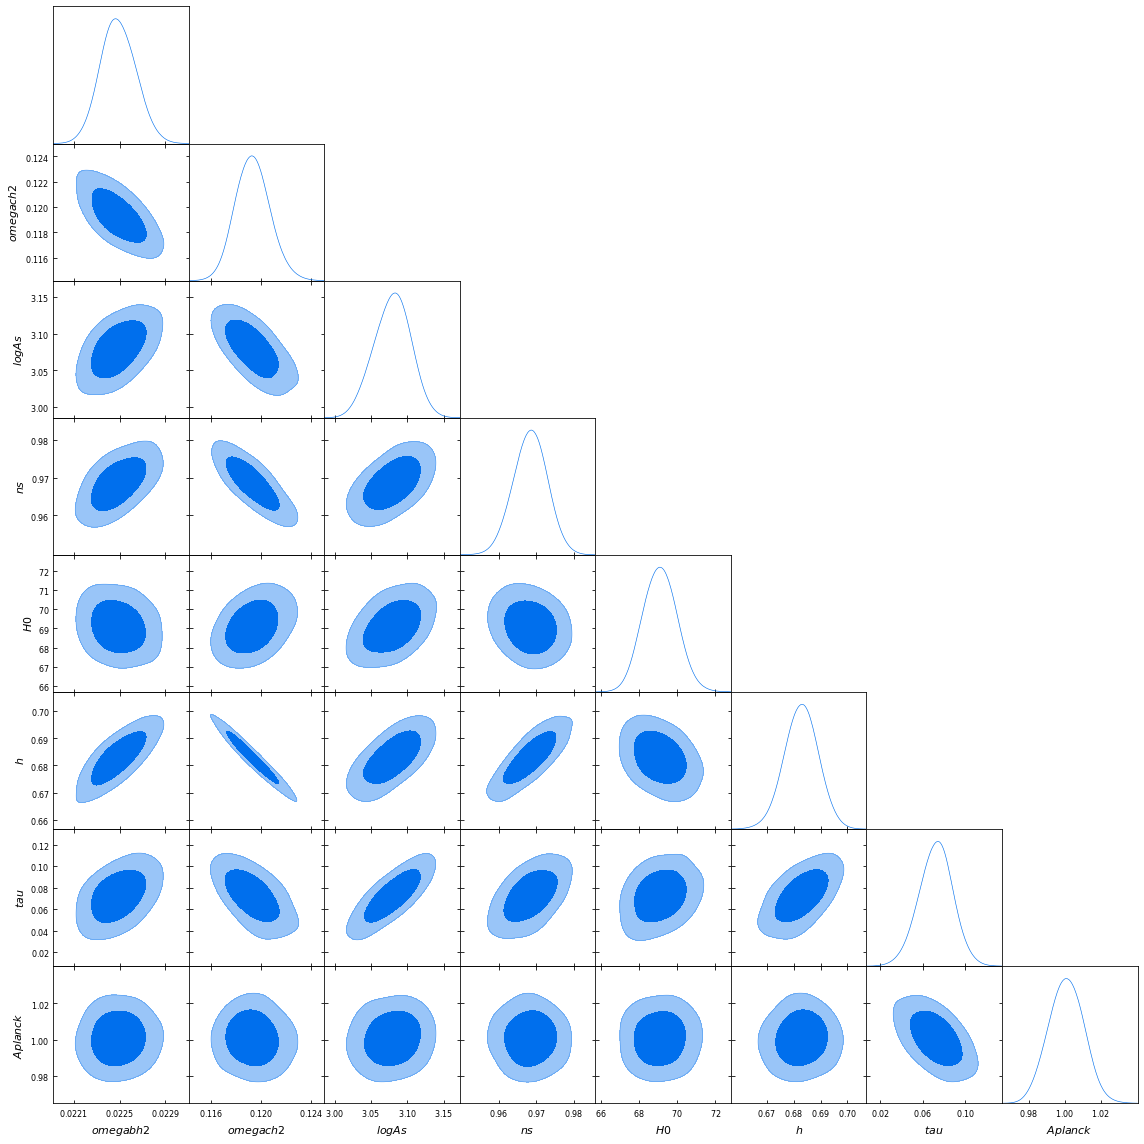

In [43]:
g = getdist.plots.get_subplot_plotter()
g.triangle_plot(chain, filled=True)

In [44]:
chain.saveAsText('joint_data', chain_index=None, make_dirs=False)

In [16]:
det = np.linalg.det(1e11*lsst_y1_cov)
print(lsst_y1_cov)
print(det)

[[ 7.42940700e-12  1.71353290e-13  1.49035770e-13 ... -8.52655218e-34
  -3.38574973e-34 -1.52792177e-34]
 [ 1.71353290e-13  4.75647120e-12  1.35963440e-13 ... -7.60910559e-34
  -3.02389147e-34 -1.36612322e-34]
 [ 1.49035770e-13  1.35963440e-13  3.04803201e-12 ... -6.66868801e-34
  -2.65350495e-34 -1.19962581e-34]
 ...
 [-8.52655218e-34 -7.60910559e-34 -6.66868801e-34 ...  6.37372143e-10
  -2.68719316e-11 -1.04269448e-10]
 [-3.38574973e-34 -3.02389147e-34 -2.65350495e-34 ... -2.68719316e-11
   4.29793961e-10 -5.94876063e-11]
 [-1.52792177e-34 -1.36612322e-34 -1.19962581e-34 ... -1.04269448e-10
  -5.94876063e-11  2.78631041e-10]]
0.0
